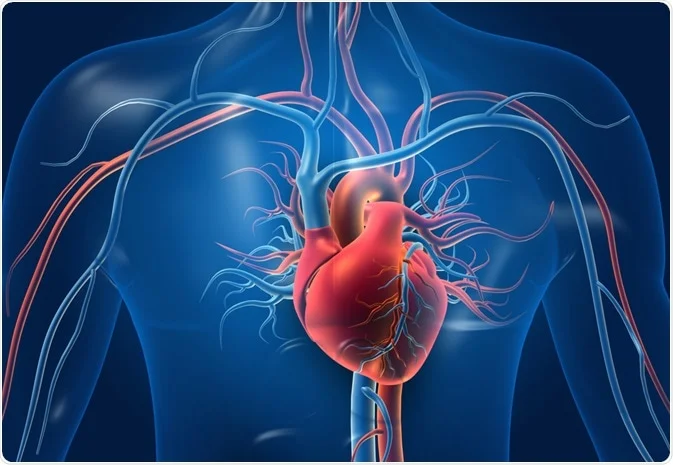

# <h1><center>Heart Failure Prediction</center></h1>

## Summary
- This notebook contains data from Kaggle.
- The information provided is about patients who have cardiovascular disease.
- This will be an attempt at being able to predict those whom are at risk based on the features below.

## Info on Data Set
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Data and info found [here](https://www.kaggle.com/fedesoriano/heart-failure-prediction?select=heart.csv).

In [59]:
#Import Utilities
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt  

import category_encoders as ce

In [17]:
# Imports 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [18]:
ls\

Heart_Failure.ipynb  heart.csv


In [19]:
df = pd.read_csv('heart.csv')

## Initial Data Exploration
- Check out the columns and rows.
- Look for nulls and other issues worth cleaning up.
- What kind of features does the data set have?

In [21]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [23]:
df.isnull().values.any()

False

In [24]:
df.isnull().sum().sum()

0

In [26]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [27]:
# Explore Categorical Columns
# Create a list of columns with the data type of object
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
df[cat_cols].describe()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


## Chest Pain Type
- The type of chest pain is important.
- This feature is worth exploring.

In [25]:
df['ChestPainType'].value_counts()
# ChestPainType seems to be skewed towards Asymptomatic.
# This initially seems plausible.

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [28]:
df['ChestPainType'].describe()

count     918
unique      4
top       ASY
freq      496
Name: ChestPainType, dtype: object

## Resting BP
- Resting blood pressure is important.
- This feature is worth exploring because it should have some relation to the target of heart disease.

In [31]:
df['RestingBP'].value_counts()

120    132
130    118
140    107
110     58
150     55
      ... 
113      1
164      1
117      1
127      1
0        1
Name: RestingBP, Length: 67, dtype: int64

In [32]:
df['RestingBP'].describe()

count    918.000000
mean     132.396514
std       18.514154
min        0.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64

## Heart Disease
- This is the target.
- This is a binary classification 

In [34]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [39]:
#Explore Target percentages
df['HeartDisease'].value_counts(normalize=True)

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64

In [40]:
df[[c for c in df.columns if df[c].dtype == 'object']].nunique().sort_values(ascending = False)

ChestPainType     4
ST_Slope          3
RestingECG        3
ExerciseAngina    2
Sex               2
dtype: int64

## Train-Test-Split

In [41]:
# Define our X and y

X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# and train test split - to create our holdout set!
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, # saving 10%
                                                  random_state=42)

# and 2nd train test split - to create our test set!
X_train, X_test, y_train, y_test = train_test_split(X_use, y_use, test_size=0.25, # saving 25%
                                                  random_state=42)

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619 entries, 734 to 300
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             619 non-null    int64  
 1   Sex             619 non-null    object 
 2   ChestPainType   619 non-null    object 
 3   RestingBP       619 non-null    int64  
 4   Cholesterol     619 non-null    int64  
 5   FastingBS       619 non-null    int64  
 6   RestingECG      619 non-null    object 
 7   MaxHR           619 non-null    int64  
 8   ExerciseAngina  619 non-null    object 
 9   Oldpeak         619 non-null    float64
 10  ST_Slope        619 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 58.0+ KB


In [44]:
# Set up lists for columns requiring different treatment
num_cols = []
ohe_cols = []
freq_cols = []

for c in X_train:
    if X_train[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X_train[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [45]:
print("NUMBER COLUMNS")
print(num_cols)
print('*'*10)
print("OHE COLUMNS")
print(ohe_cols)
print('*'*10)
print("FREQ COLUMNS")
print(freq_cols)

NUMBER COLUMNS
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
**********
OHE COLUMNS
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
**********
FREQ COLUMNS
[]


In [49]:
print(X_train['Sex'].value_counts())
print(X_train['ST_Slope'].value_counts())

M    487
F    132
Name: Sex, dtype: int64
Flat    321
Up      260
Down     38
Name: ST_Slope, dtype: int64


In [50]:
df.any(bool_only=None)

Age               True
Sex               True
ChestPainType     True
RestingBP         True
Cholesterol       True
FastingBS         True
RestingECG        True
MaxHR             True
ExerciseAngina    True
Oldpeak           True
ST_Slope          True
HeartDisease      True
dtype: bool

In [61]:
ohe_transformer = Pipeline(steps=[('oh_encoder', OneHotEncoder(handle_unknown='error'))])
preprocessor = ColumnTransformer(
    transformers=[('ohe', ohe_transformer, ohe_cols)])

In [62]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('oh_encoder',
                                                  OneHotEncoder())]),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope'])])

## Baseline Understanding

In [63]:
y_train.value_counts()

1    345
0    274
Name: HeartDisease, dtype: int64

In [64]:
y_train.value_counts(normalize=True)

1    0.557351
0    0.442649
Name: HeartDisease, dtype: float64

In [65]:
# Create a pipeline for default Desicion Tree Classifier
pipe_dtc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dtc', DecisionTreeClassifier(random_state=42))
])

In [66]:
#Cross validate on y_train
cv = cross_validate(pipe_dtc, X_train, y_train, return_train_score=True, \
                    scoring=['accuracy', 'precision','roc_auc'])
cv

{'fit_time': array([0.00958633, 0.00547194, 0.00428295, 0.004179  , 0.00419116]),
 'score_time': array([0.00963783, 0.00781298, 0.0064261 , 0.00689411, 0.00549793]),
 'test_accuracy': array([0.87096774, 0.7983871 , 0.83870968, 0.76612903, 0.7398374 ]),
 'train_accuracy': array([0.85454545, 0.86666667, 0.85454545, 0.86868687, 0.87701613]),
 'test_precision': array([0.90769231, 0.78205128, 0.88888889, 0.8030303 , 0.76811594]),
 'train_precision': array([0.87226277, 0.90697674, 0.88059701, 0.88363636, 0.87456446]),
 'test_roc_auc': array([0.90237154, 0.78471673, 0.88208169, 0.81370224, 0.79723564]),
 'train_roc_auc': array([0.929414  , 0.94263285, 0.92890113, 0.94208689, 0.94017622])}

In [67]:
pipe_dtc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('oh_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('dtc', DecisionTreeClassifier(random_state=42))])

In [68]:
#Make predictions for model
train_preds = pipe_dtc.predict(X_train)
train_probas = pipe_dtc.predict_proba(X_train)[:,1]
test_preds = pipe_dtc.predict(X_test)
test_probas = pipe_dtc.predict_proba(X_test)[:,1]

/Users/patrickryan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


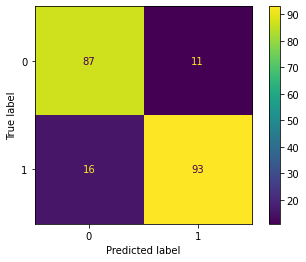

In [70]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_dtc, X_test, y_test)

In [71]:
# Evaluate Train and Test Scores
print("Train Scores:")
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Train Precision: {precision_score(y_train, train_preds)}")
print(f"Train Recall: {recall_score(y_train, train_preds)}")
print(f"Train F1-Score: {f1_score(y_train, train_preds)}")
print(f"Train Roc-Auc Score: {roc_auc_score(y_train, train_probas)}")
print("---------------")
print("Test Scores:")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
print(f"Test Precision: {precision_score(y_test, test_preds)}")
print(f"Test Recall: {recall_score(y_test, test_preds)}")
print(f"Test F1-Score: {f1_score(y_test, test_preds)}")
print(f"Test Roc-Auc Score: {roc_auc_score(y_test, test_probas)}")

Train Scores:
Train Accuracy: 0.8578352180936996
Train Precision: 0.8790560471976401
Train Recall: 0.863768115942029
Train F1-Score: 0.8713450292397661
Train Roc-Auc Score: 0.9315296731196445
---------------
Test Scores:
Test Accuracy: 0.8695652173913043
Test Precision: 0.8942307692307693
Test Recall: 0.8532110091743119
Test F1-Score: 0.8732394366197184
Test Roc-Auc Score: 0.8645852836547463


## Random Forest Classifier

In [72]:
#Instantiate a Random Forest Classifier inside this new pipeline
pipe_rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfc', RandomForestClassifier(random_state=42))
])

In [73]:
#Cross Validate on X_train and y_train
cross_validate(pipe_rfc, X_train, y_train, return_train_score=True, \
               scoring=['accuracy', 'precision','roc_auc'])

{'fit_time': array([0.1320467 , 0.10671687, 0.09514332, 0.09855914, 0.10302091]),
 'score_time': array([0.02487135, 0.02418089, 0.0216949 , 0.02304888, 0.02527905]),
 'test_accuracy': array([0.84677419, 0.80645161, 0.83870968, 0.77419355, 0.7804878 ]),
 'train_accuracy': array([0.85454545, 0.86666667, 0.85454545, 0.86868687, 0.87701613]),
 'test_precision': array([0.86764706, 0.78481013, 0.88888889, 0.80597015, 0.79166667]),
 'train_precision': array([0.85664336, 0.88888889, 0.87777778, 0.88086643, 0.8668942 ]),
 'test_roc_auc': array([0.90079051, 0.82938076, 0.8859025 , 0.82529644, 0.84728932]),
 'train_roc_auc': array([0.92676692, 0.93986996, 0.92638641, 0.93967143, 0.93694829])}

In [74]:
#Fit the Model to X_train and y_train
pipe_rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('oh_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('rfc', RandomForestClassifier(random_state=42))])

In [75]:
#Make predictions with this model
train_preds = pipe_rfc.predict(X_train)
train_probas = pipe_rfc.predict_proba(X_train)[:,1]
test_preds = pipe_rfc.predict(X_test)
test_probas = pipe_rfc.predict_proba(X_test)[:,1]

/Users/patrickryan/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


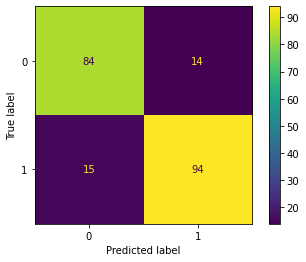

In [76]:
#Visualize Confusion Matrix
plot_confusion_matrix(pipe_rfc, X_test, y_test)